In [1]:
% load_ext autoreload
% autoreload 2

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import pystan
import seaborn as sns
import numpy as np
import copy
from scipy.stats import norm
import analysis

redownload_indiana_data = False
indiana_data_filename = 'indiana_data.json'    


# Indiana data. Downloaded 8/16/2020.
if redownload_indiana_data:
    os.system('curl https://www.coronavirus.in.gov/map/covid-19-indiana-daily-report-current.topojson > %s' % indiana_data_filename)

# data across 6 states from the COVID tracking project. 

Fraction of tests 


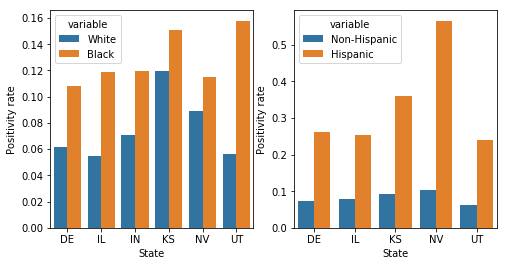

Attempting to correct for differential rates of missing data between positive and negative tests


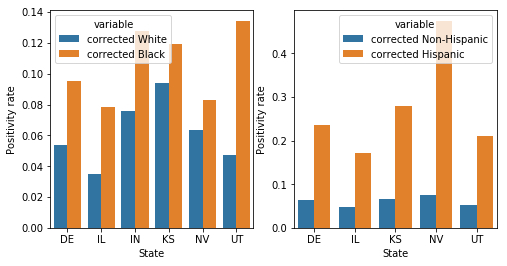

In [2]:
multistate_d = pd.read_csv('covid_tracking_racial_disparities_data.csv')

race_ethnicities_to_consider = ['White', 'Black', 'Hispanic', 'Non-Hispanic']

multistate_d = multistate_d.dropna(subset=['State'] + 
                            ['Known %s positive tests' % a for a in race_ethnicities_to_consider] + 
                            ['Known %s negative tests' % a for a in race_ethnicities_to_consider])


for k in ['% Unk. race positive tests', 
              '% Unk. ethnicity positive tests', 
              '% Unk. race negative tests',
              '% Unk. ethnicity negative tests']:
    multistate_d[k.replace('% Unk.', 'Prop known')] = 1 - 1.*multistate_d[k].map(lambda x:float(x[:-1])/100)
for k in race_ethnicities_to_consider:
    multistate_d[k] = (multistate_d['Known %s positive tests' % k] / 
                                                       (multistate_d['Known %s positive tests' % k]  + 
                                                        multistate_d['Known %s negative tests' % k] ))
    
    if k in ['White', 'Black']:
        corrected_pos_tests = multistate_d['Known %s positive tests' % k]/multistate_d['Prop known race positive tests']
        corrected_neg_tests = multistate_d['Known %s negative tests' % k]/multistate_d['Prop known race negative tests']
    else:
        corrected_pos_tests = multistate_d['Known %s positive tests' % k]/multistate_d['Prop known ethnicity positive tests']
        corrected_neg_tests = multistate_d['Known %s negative tests' % k]/multistate_d['Prop known ethnicity negative tests']
    multistate_d['corrected %s' % k] = (corrected_pos_tests/(corrected_pos_tests + corrected_neg_tests))
    
        

for correct_for_missingness in [False, True]:
    if not correct_for_missingness:
        pos_fracs = multistate_d[['State'] + race_ethnicities_to_consider]
        print("Fraction of tests ")
    else:
        print("Attempting to correct for differential rates of missing data between positive and negative tests")
        pos_fracs = multistate_d[['State'] + ['corrected %s' % a for a in race_ethnicities_to_consider]]
    melted_data = pos_fracs.melt(id_vars=['State'])

    
    fig = plt.figure(figsize=[8, 4])

    for plt_idx, group in enumerate(['race', 'ethnicity']):
        ax = fig.add_subplot(1, 2, plt_idx + 1)
        if group == 'race':
            hue_order = ['White', 'Black']
            if correct_for_missingness:
                hue_order = ['corrected %s' % a for a in hue_order]
            data_to_use = melted_data.loc[melted_data['variable'].map(lambda x:x in hue_order)]
        else:
            hue_order = ['Non-Hispanic', 'Hispanic']
            if correct_for_missingness:
                hue_order = ['corrected %s' % a for a in hue_order]
            data_to_use = melted_data.loc[melted_data['variable'].map(lambda x:x in hue_order) & 
                                          (melted_data['State'] != 'IN')]
        
            
        sns.barplot(data=data_to_use, x='State', y='value', hue='variable', hue_order=hue_order)
        #plt.title('%s' % group)
        plt.ylabel("Positivity rate")
    plt.show()





In [3]:
# lots of missing data though. 

multistate_d[['State', '% Unk. race positive tests', 
              '% Unk. ethnicity positive tests', 
              '% Unk. race negative tests',
              '% Unk. ethnicity negative tests']]

,State,% Unk. race positive tests,% Unk. ethnicity positive tests,% Unk. race negative tests,% Unk. ethnicity negative tests
9,DE,9%,9%,21.08%,21.08%
16,IL,24%,24%,52.17%,53.82%
17,IN,23%,55%,17.17%,56.55%
18,KS,17%,22%,36.55%,46.22%
36,NV,39%,39%,57.75%,57.75%
48,UT,10%,11%,25.47%,25.47%


# Process data three different ways, and fit two models, as robustness checks. 




**************Analyzing data using race processing method reweight_by_hispanic_and_unknown, model poisson_mixture_model_no_deltas.stan
Statistics on missing data
       case_eth_known  case_race_known  test_eth_known  test_race_known
count       92.000000        92.000000       92.000000        92.000000
mean         0.529238         0.822576        0.517792         0.873399
std          0.157101         0.087101        0.159868         0.076264
min          0.152682         0.510638        0.162540         0.508073
25%          0.426334         0.782024        0.408626         0.846639
50%          0.531616         0.830474        0.514476         0.890740
75%          0.631481         0.886202        0.634116         0.924563
max          0.869565         0.963158        0.811825         0.976703
Number of counties: 92; 276 rows; total cases: 80415; total INDIVIDUALS TESTED 906851
            count          mean           std  min     25%     50%       75%  \
cases       276.0    

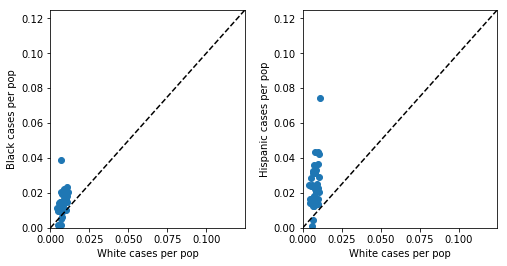

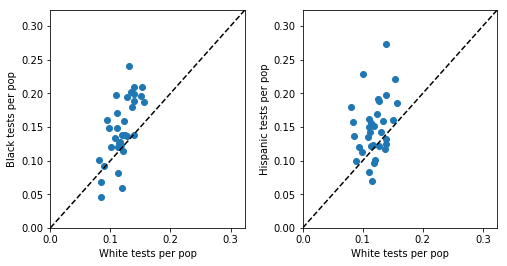

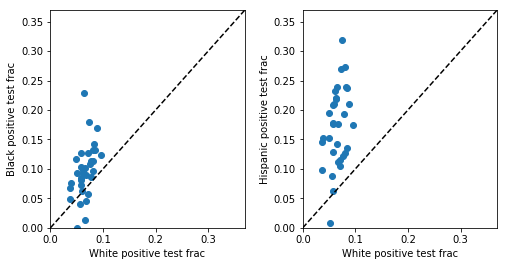

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ca389039779a2658e22492f1c8ecc00 NOW.


Beginning model fitting using model poisson_mixture_model_no_deltas.stan with 33 locations and 3 race groups, 99 rows total


Finished fitting model in 40.020 seconds
Rhat ranges from 0.99981-1.00170 with 1 Nans in phi_d[1]
Inference for Stan model: anon_model_6ca389039779a2658e22492f1c8ecc00.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t    1.19  5.0e-4   0.08   1.04   1.13   1.18   1.24   1.36  28842    1.0
mu_delta   0.38  1.1e-3   0.07   0.25   0.33   0.38   0.42    0.5 3418.0    1.0
phi_r[1]  -3.04  1.3e-3   0.07  -3.17  -3.09  -3.04   -3.0  -2.91 2650.0    1.0
phi_r[2]  -3.94  1.3e-3   0.07  -4.07  -3.99  -3.94   -3.9  -3.81 2676.0    1.0
phi_r[3]  -4.44  1.4e-3   0.07  -4.58  -4.49  -4.44  -4.39   -4.3 2650.0    1.0

Samples were drawn using NUTS at Mon Aug 24 17:13:55 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


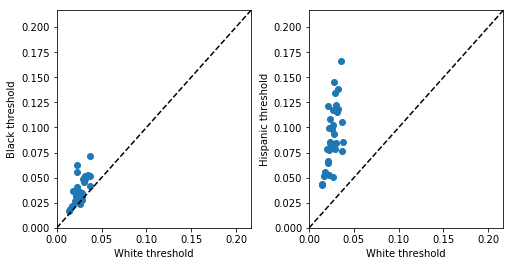

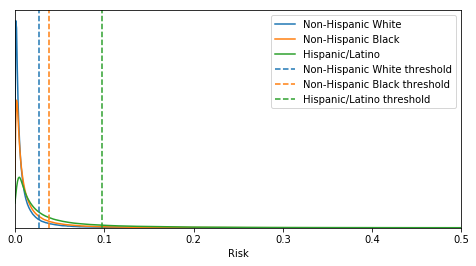

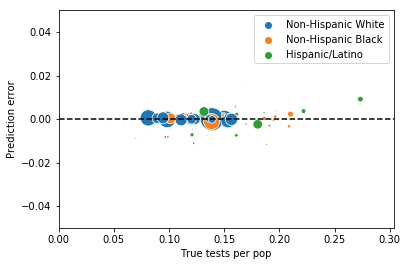

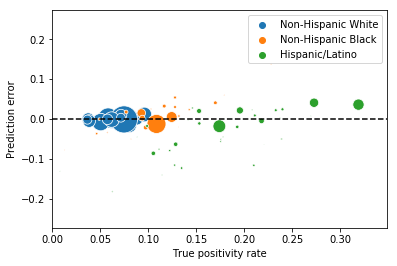

                    hit_rate_err  relative_hit_rate_err  search_rate_err
race_group                                                              
Hispanic/Latino         0.052350               0.248562         0.005111
Non-Hispanic Black      0.029241               0.316103         0.002669
Non-Hispanic White      0.003819               0.058962         0.000280



Do counties which are more white have lower thresholds and positivity rates?
Corr between county_frac_white and Hispanic/Latino mean_threshold: spearman 0.079; pearsonr -0.008
Corr between county_frac_white and Non-Hispanic Black mean_threshold: spearman 0.007; pearsonr -0.120
Corr between county_frac_white and Non-Hispanic White mean_threshold: spearman -0.138; pearsonr -0.302
Corr between county_frac_white and average mean_threshold across ALL groups: spearman 0.020; pearsonr -0.086
Corr between county_frac_white and Hispanic/Latino pos_frac: spearman -0.194; pearsonr -0.353
Corr between county_frac_white and Non-Hispanic 

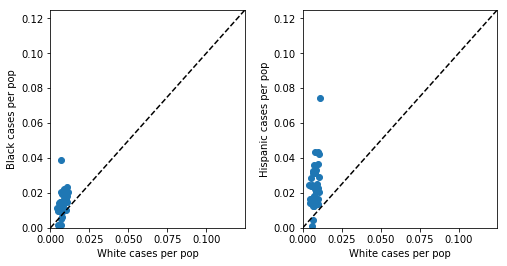

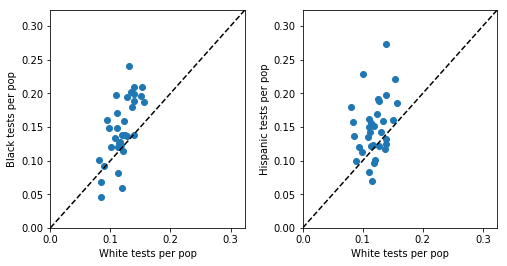

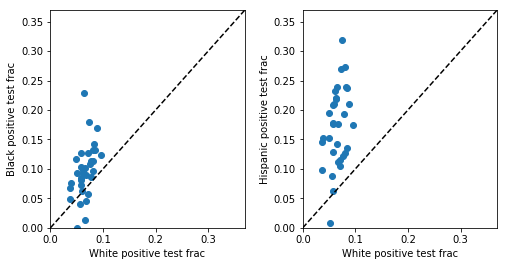

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99470c7a3a0b35d0861390e115038847 NOW.


Beginning model fitting using model binomial_mixture_model_no_deltas.stan with 33 locations and 3 race groups, 99 rows total


Finished fitting model in 41.113 seconds
Rhat ranges from 0.99981-1.00158 with 1 Nans in phi_d[1]
Inference for Stan model: anon_model_99470c7a3a0b35d0861390e115038847.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t    1.19  5.0e-4   0.08   1.04   1.13   1.19   1.24   1.37  28444    1.0
mu_delta   0.34  1.1e-3   0.07    0.2    0.3   0.34   0.38   0.46 3461.0    1.0
phi_r[1]   -3.0  1.3e-3   0.07  -3.13  -3.05   -3.0  -2.96  -2.86 2816.0    1.0
phi_r[2]   -3.9  1.3e-3   0.07  -4.03  -3.95   -3.9  -3.86  -3.76 2828.0    1.0
phi_r[3]   -4.4  1.3e-3   0.07  -4.53  -4.45   -4.4  -4.35  -4.26 2789.0    1.0

Samples were drawn using NUTS at Mon Aug 24 17:15:36 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


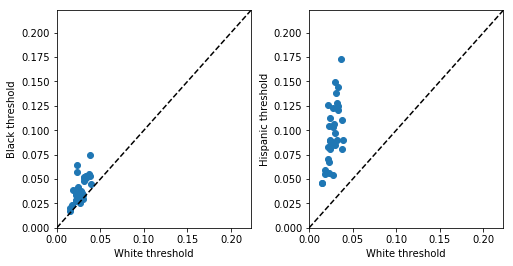

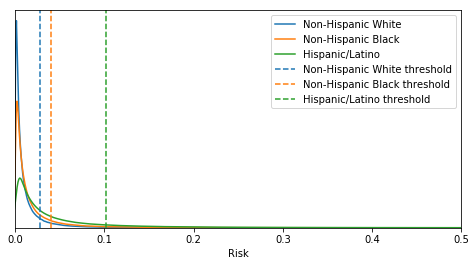

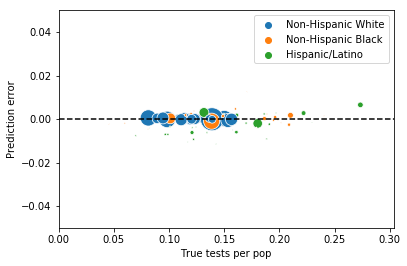

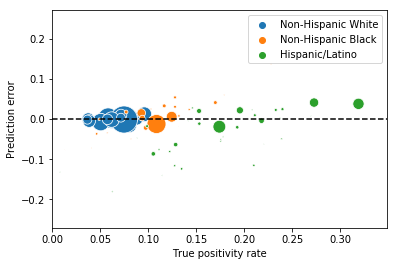

                    hit_rate_err  relative_hit_rate_err  search_rate_err
race_group                                                              
Hispanic/Latino         0.052714               0.250141         0.004201
Non-Hispanic Black      0.029239               0.316732         0.002214
Non-Hispanic White      0.003861               0.059618         0.000241



Do counties which are more white have lower thresholds and positivity rates?
Corr between county_frac_white and Hispanic/Latino mean_threshold: spearman 0.070; pearsonr -0.006
Corr between county_frac_white and Non-Hispanic Black mean_threshold: spearman 0.018; pearsonr -0.126
Corr between county_frac_white and Non-Hispanic White mean_threshold: spearman -0.133; pearsonr -0.299
Corr between county_frac_white and average mean_threshold across ALL groups: spearman 0.017; pearsonr -0.086
Corr between county_frac_white and Hispanic/Latino pos_frac: spearman -0.194; pearsonr -0.353
Corr between county_frac_white and Non-Hispanic 

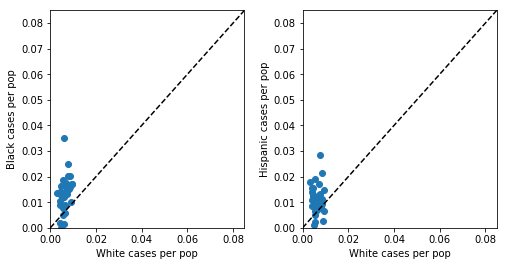

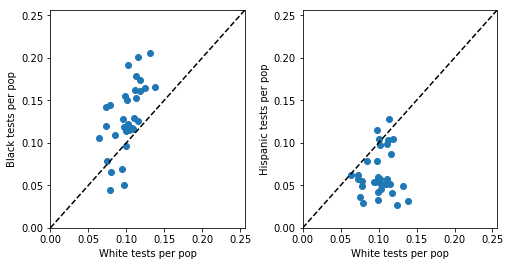

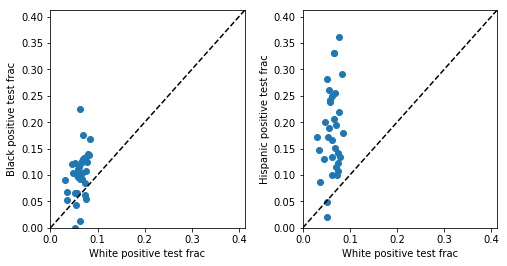

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ca389039779a2658e22492f1c8ecc00 NOW.


Beginning model fitting using model poisson_mixture_model_no_deltas.stan with 33 locations and 3 race groups, 99 rows total


Finished fitting model in 78.323 seconds
Rhat ranges from 0.99981-1.00255 with 1 Nans in phi_d[1]
Inference for Stan model: anon_model_6ca389039779a2658e22492f1c8ecc00.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t    1.41  5.5e-4    0.1   1.23   1.34   1.41   1.48   1.63  33311    1.0
mu_delta  -0.12  2.8e-3   0.13   -0.4   -0.2  -0.11  -0.02   0.12 2259.0    1.0
phi_r[1]  -2.82  3.7e-3   0.17  -3.14  -2.94  -2.83  -2.71  -2.49 2103.0    1.0
phi_r[2]  -3.36  2.9e-3   0.13   -3.6  -3.45  -3.36  -3.27  -3.09 2068.0    1.0
phi_r[3]   -4.1  3.1e-3   0.14  -4.36   -4.2  -4.11  -4.01  -3.83 2058.0    1.0

Samples were drawn using NUTS at Mon Aug 24 17:17:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


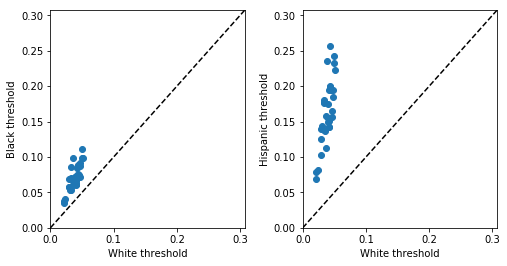

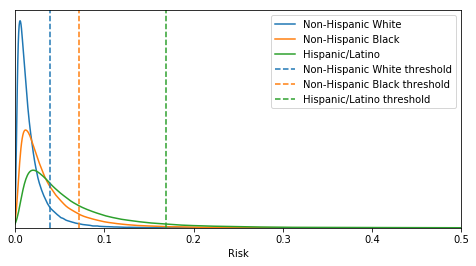

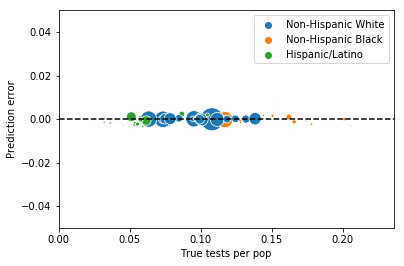

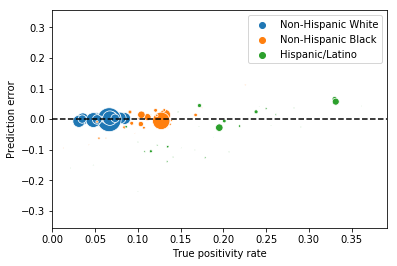

                    hit_rate_err  relative_hit_rate_err  search_rate_err
race_group                                                              
Hispanic/Latino         0.070517               0.304022         0.001777
Non-Hispanic Black      0.030207               0.269563         0.001640
Non-Hispanic White      0.003274               0.054720         0.000129



Do counties which are more white have lower thresholds and positivity rates?
Corr between county_frac_white and Hispanic/Latino mean_threshold: spearman 0.090; pearsonr 0.036
Corr between county_frac_white and Non-Hispanic Black mean_threshold: spearman 0.083; pearsonr 0.008
Corr between county_frac_white and Non-Hispanic White mean_threshold: spearman -0.057; pearsonr -0.149
Corr between county_frac_white and average mean_threshold across ALL groups: spearman 0.106; pearsonr 0.009
Corr between county_frac_white and Hispanic/Latino pos_frac: spearman -0.272; pearsonr -0.324
Corr between county_frac_white and Non-Hispanic Bla

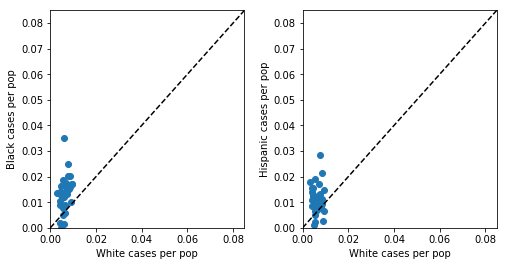

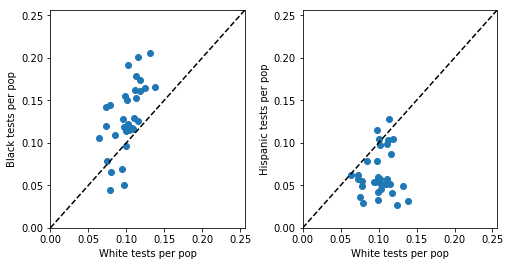

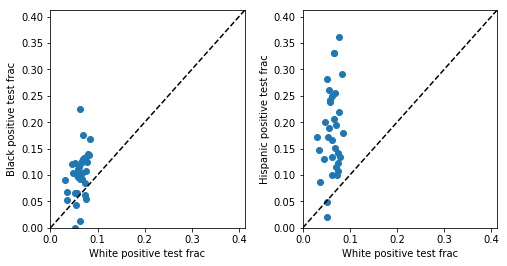

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99470c7a3a0b35d0861390e115038847 NOW.


Beginning model fitting using model binomial_mixture_model_no_deltas.stan with 33 locations and 3 race groups, 99 rows total


Finished fitting model in 70.939 seconds
Rhat ranges from 0.99982-1.00389 with 1 Nans in phi_d[1]
Inference for Stan model: anon_model_99470c7a3a0b35d0861390e115038847.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t    1.41  5.5e-4    0.1   1.23   1.34   1.41   1.47   1.62  32488    1.0
mu_delta  -0.14  3.4e-3   0.14  -0.43  -0.23  -0.13  -0.04   0.11 1613.0    1.0
phi_r[1]   -2.8  4.4e-3   0.17  -3.12  -2.92   -2.8  -2.68  -2.46 1512.0    1.0
phi_r[2]  -3.33  3.4e-3   0.13  -3.58  -3.43  -3.34  -3.25  -3.07 1490.0    1.0
phi_r[3]  -4.08  3.7e-3   0.14  -4.35  -4.18  -4.09  -3.99   -3.8 1464.0    1.0

Samples were drawn using NUTS at Mon Aug 24 17:19:59 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


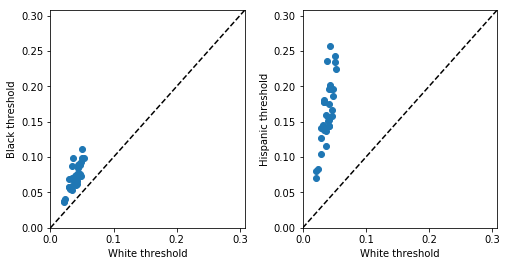

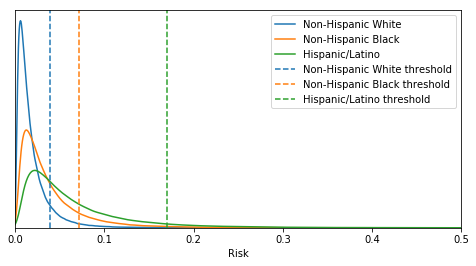

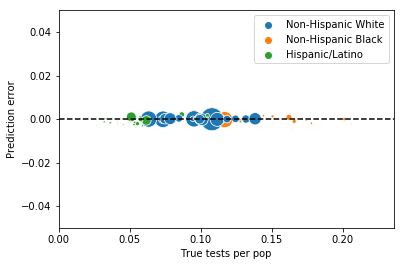

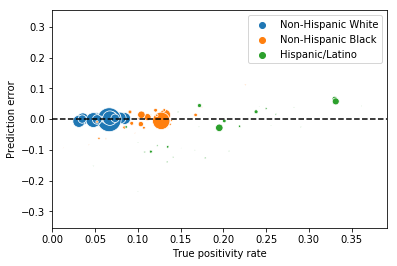

                    hit_rate_err  relative_hit_rate_err  search_rate_err
race_group                                                              
Hispanic/Latino         0.070603               0.304478         0.001607
Non-Hispanic Black      0.030218               0.269780         0.001380
Non-Hispanic White      0.003274               0.054730         0.000115



Do counties which are more white have lower thresholds and positivity rates?
Corr between county_frac_white and Hispanic/Latino mean_threshold: spearman 0.090; pearsonr 0.035
Corr between county_frac_white and Non-Hispanic Black mean_threshold: spearman 0.083; pearsonr 0.007
Corr between county_frac_white and Non-Hispanic White mean_threshold: spearman -0.057; pearsonr -0.147
Corr between county_frac_white and average mean_threshold across ALL groups: spearman 0.098; pearsonr 0.008
Corr between county_frac_white and Hispanic/Latino pos_frac: spearman -0.272; pearsonr -0.324
Corr between county_frac_white and Non-Hispanic Bla

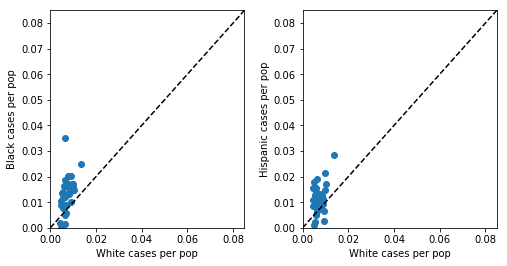

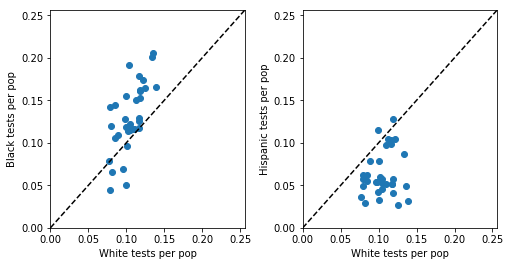

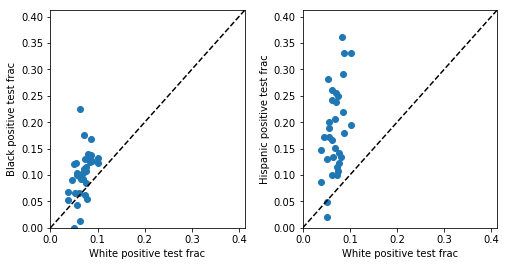

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6ca389039779a2658e22492f1c8ecc00 NOW.


Beginning model fitting using model poisson_mixture_model_no_deltas.stan with 33 locations and 3 race groups, 99 rows total


Finished fitting model in 68.946 seconds
Rhat ranges from 0.99981-1.00161 with 1 Nans in phi_d[1]
Inference for Stan model: anon_model_6ca389039779a2658e22492f1c8ecc00.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t    1.41  5.4e-4    0.1   1.23   1.34    1.4   1.47   1.62  34824    1.0
mu_delta   0.24  2.0e-3   0.11   0.02   0.17   0.25   0.31   0.44 2926.0    1.0
phi_r[1]  -3.35  3.0e-3   0.15  -3.64  -3.46  -3.35  -3.25  -3.04 2698.0    1.0
phi_r[2]  -3.75  2.3e-3   0.12  -3.97  -3.83  -3.75  -3.68  -3.51 2614.0    1.0
phi_r[3]  -4.25  2.4e-3   0.12  -4.48  -4.34  -4.26  -4.18  -4.01 2609.0    1.0

Samples were drawn using NUTS at Mon Aug 24 17:22:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


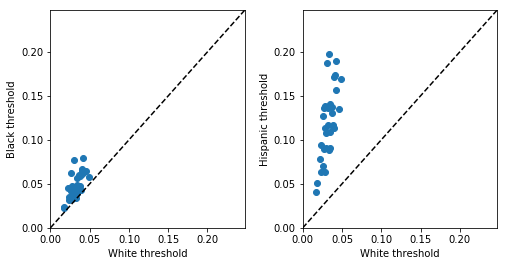

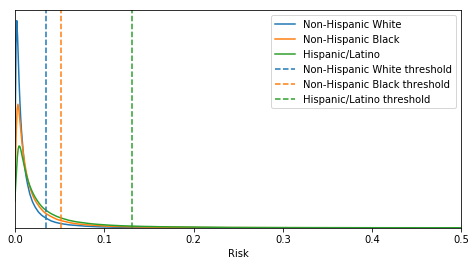

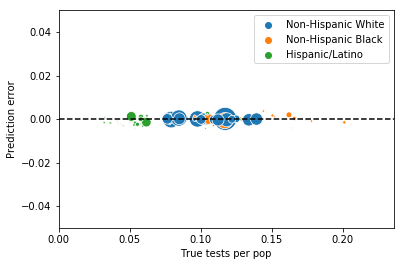

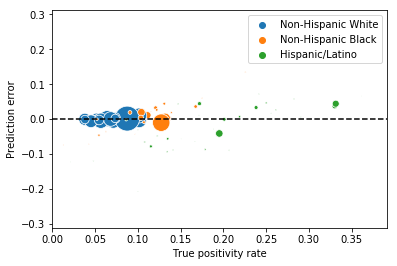

                    hit_rate_err  relative_hit_rate_err  search_rate_err
race_group                                                              
Hispanic/Latino         0.054484               0.267767         0.001747
Non-Hispanic Black      0.027997               0.290449         0.001979
Non-Hispanic White      0.002651               0.039682         0.000149



Do counties which are more white have lower thresholds and positivity rates?
Corr between county_frac_white and Hispanic/Latino mean_threshold: spearman -0.040; pearsonr -0.179
Corr between county_frac_white and Non-Hispanic Black mean_threshold: spearman -0.169; pearsonr -0.258
Corr between county_frac_white and Non-Hispanic White mean_threshold: spearman -0.327; pearsonr -0.427
Corr between county_frac_white and average mean_threshold across ALL groups: spearman -0.130; pearsonr -0.256
Corr between county_frac_white and Hispanic/Latino pos_frac: spearman -0.272; pearsonr -0.324
Corr between county_frac_white and Non-Hispan

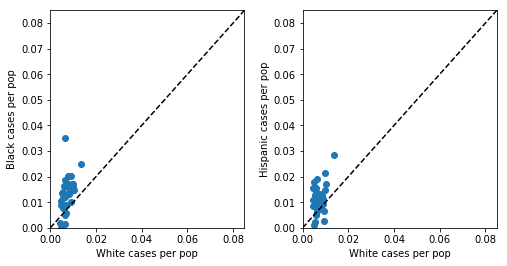

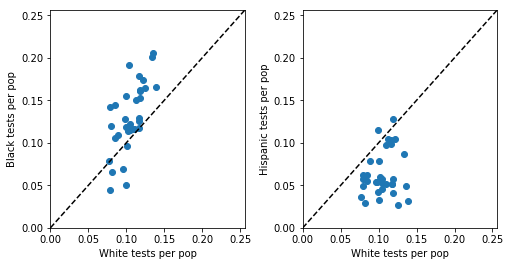

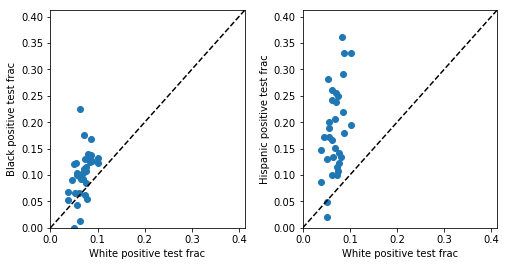

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_99470c7a3a0b35d0861390e115038847 NOW.


Beginning model fitting using model binomial_mixture_model_no_deltas.stan with 33 locations and 3 race groups, 99 rows total


Finished fitting model in 67.728 seconds
Rhat ranges from 0.99981-1.00117 with 1 Nans in phi_d[1]
Inference for Stan model: anon_model_99470c7a3a0b35d0861390e115038847.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_t    1.41  5.5e-4    0.1    1.23   1.34    1.4   1.47   1.62  33182    1.0
mu_delta   0.23  2.0e-3   0.11 -3.3e-4   0.16   0.23    0.3   0.42 2790.0    1.0
phi_r[1]  -3.33  3.1e-3   0.16   -3.61  -3.43  -3.33  -3.23   -3.0 2533.0    1.0
phi_r[2]  -3.73  2.4e-3   0.12   -3.95  -3.81  -3.74  -3.66  -3.49 2438.0    1.0
phi_r[3]  -4.24  2.5e-3   0.12   -4.46  -4.32  -4.24  -4.16  -3.99 2426.0    1.0

Samples were drawn using NUTS at Mon Aug 24 17:24:09 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


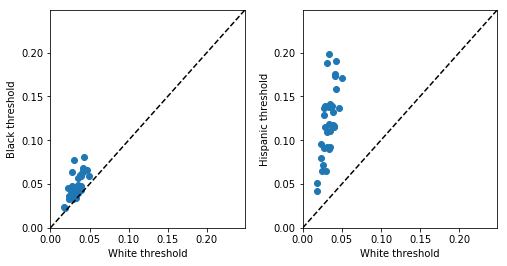

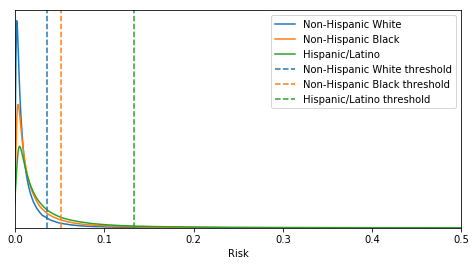

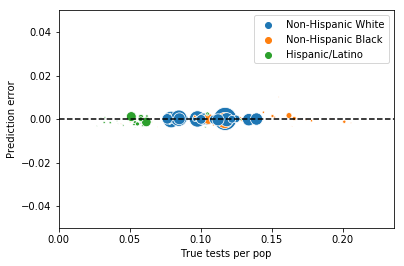

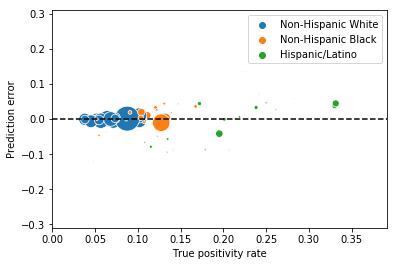

                    hit_rate_err  relative_hit_rate_err  search_rate_err
race_group                                                              
Hispanic/Latino         0.054624               0.268465         0.001606
Non-Hispanic Black      0.028035               0.291129         0.001714
Non-Hispanic White      0.002661               0.039813         0.000133



Do counties which are more white have lower thresholds and positivity rates?
Corr between county_frac_white and Hispanic/Latino mean_threshold: spearman -0.047; pearsonr -0.181
Corr between county_frac_white and Non-Hispanic Black mean_threshold: spearman -0.169; pearsonr -0.261
Corr between county_frac_white and Non-Hispanic White mean_threshold: spearman -0.327; pearsonr -0.426
Corr between county_frac_white and average mean_threshold across ALL groups: spearman -0.138; pearsonr -0.258
Corr between county_frac_white and Hispanic/Latino pos_frac: spearman -0.272; pearsonr -0.324
Corr between county_frac_white and Non-Hispan

In [4]:
all_aggregate_thresholds = []
for min_race_group_cutoffs in [{'min_race_group_frac':0, 
                                        'min_race_group_n':500}]:
    for race_processing_method in ['reweight_by_hispanic_and_unknown', 'subtract_hispanic_from_white','just_use_raw_numbers']:
        for model_filename in ['poisson_mixture_model_no_deltas.stan', 
                               'binomial_mixture_model_no_deltas.stan']:
        
            use_multinomial_model = model_filename == 'fast_multinomial_model_no_deltas.stan'
            print("\n\n\n**************Analyzing data using race processing method %s, model %s" % (race_processing_method, model_filename))
            indiana_d = analysis.load_indiana_data(indiana_data_filename, race_processing_method)  

            # filter raw data for counties that have significant minority populations, and plot raw data stats. 
            results = analysis.filter_and_annotate_raw_data(indiana_d,**min_race_group_cutoffs)
            fit = analysis.fit_model(model_filename, results, use_multinomial_model)
            aggregate_thresholds = analysis.analyze_fitted_model(fit, results, use_multinomial_model)
            aggregate_thresholds['data_processing_method'] = race_processing_method
            aggregate_thresholds['model'] = model_filename
            aggregate_thresholds['min_race_group_frac'] = min_race_group_cutoffs['min_race_group_frac']
            aggregate_thresholds['min_race_group_n'] = min_race_group_cutoffs['min_race_group_n']
            all_aggregate_thresholds.append(aggregate_thresholds)


In [5]:
all_aggregate_thresholds = pd.DataFrame(all_aggregate_thresholds)
for k in ['Hispanic/Latino', 'Non-Hispanic Black', 'Non-Hispanic White']:
    all_aggregate_thresholds[k + '_all_draws'] = all_aggregate_thresholds[k].map(lambda x:x['all_draws'])
    all_aggregate_thresholds[k] = all_aggregate_thresholds[k].map(lambda x:x['mean'])
all_aggregate_thresholds['Hispanic_white_ratio'] = (all_aggregate_thresholds['Hispanic/Latino'] / 
                                                    all_aggregate_thresholds['Non-Hispanic White'])
all_aggregate_thresholds['Black_white_ratio'] = (all_aggregate_thresholds['Non-Hispanic Black'] / 
                                                    all_aggregate_thresholds['Non-Hispanic White'])
assert (all_aggregate_thresholds['Hispanic_white_ratio'] > 1).all()
assert (all_aggregate_thresholds['Black_white_ratio'] > 1).all()
(all_aggregate_thresholds[['data_processing_method', 
                                        'model', 
                                        'Hispanic_white_ratio', 
                                        'Black_white_ratio',
                                        'Hispanic/Latino', 
                                        'Non-Hispanic Black', 
                                        'Non-Hispanic White']])

,data_processing_method,model,Hispanic_white_ratio,Black_white_ratio,Hispanic/Latino,Non-Hispanic Black,Non-Hispanic White
0,reweight_by_hispanic_and_unknown,poisson_mixture_model_no_deltas.stan,3.606959,1.418969,0.097006,0.038162,0.026894
1,reweight_by_hispanic_and_unknown,binomial_mixture_model_no_deltas.stan,3.589642,1.420976,0.101365,0.040126,0.028238
2,subtract_hispanic_from_white,poisson_mixture_model_no_deltas.stan,4.333701,1.823587,0.168870,0.071059,0.038967
3,subtract_hispanic_from_white,binomial_mixture_model_no_deltas.stan,4.316068,1.824652,0.170206,0.071956,0.039435
4,just_use_raw_numbers,poisson_mixture_model_no_deltas.stan,3.756092,1.453816,0.131463,0.050884,0.035000
5,just_use_raw_numbers,binomial_mixture_model_no_deltas.stan,3.737848,1.454414,0.132840,0.051689,0.035539
